In [35]:
# Notebook Setup
%matplotlib inline

# Libraries
import pandas as pd

# Get Dataset (optional)

In [36]:
# Get current dataset
import urllib.request

with urllib.request.urlopen('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv') as f:
    #html = f.read().decode('utf-8')
    df = pd.read_csv(f, encoding = 'utf-8', index_col = [1,0], header = 0)

# Save a cached version    
df.to_pickle("Current.pic")


# Read Dataset

In [37]:
df = pd.read_pickle("Current.pic").sort_index()
df.tail()

Confirmed  Recovered  Deaths
Country  Date                                    
Zimbabwe 2020-07-12        985        328      18
         2020-07-13       1034        343      19
         2020-07-14       1064        343      20
         2020-07-15       1089        395      20
         2020-07-16       1362        425      23

# Plot

## 1. Compute metrics of interest

In [38]:
# Daily new infections
df["NewConfirmed"] = df.groupby(level = 0)["Confirmed"].diff()

# Daily new infections
df["NewRemoved"] = df.groupby(level = 0)["Recovered"].diff() + df.groupby(level = 0)["Deaths"].diff()

# Daily new infections (averaged over 7 days to eliminate the weekly testing cycles)
df["weeklyAverage"] = df.groupby(level = 0)["NewConfirmed"].rolling(7, center = True ).mean().values

## 2. Select countries and plotting period

In [39]:
#Find name of country if needed
[country for country in df.index.levels[0] if "U" in country ]

['US',
 'Uganda',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'Uruguay',
 'Uzbekistan']

In [47]:
#Select
countries = ['Germany','United Kingdom', 'US','Italy']
lastXdays = 130

## 3. Plot logarithmic timelines of new infections

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


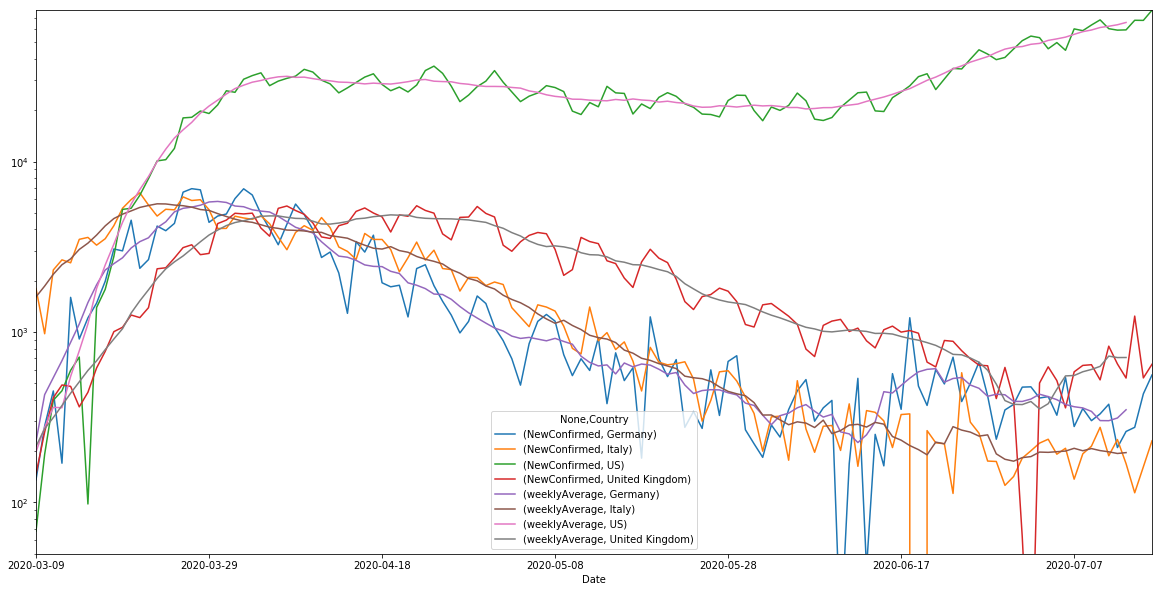

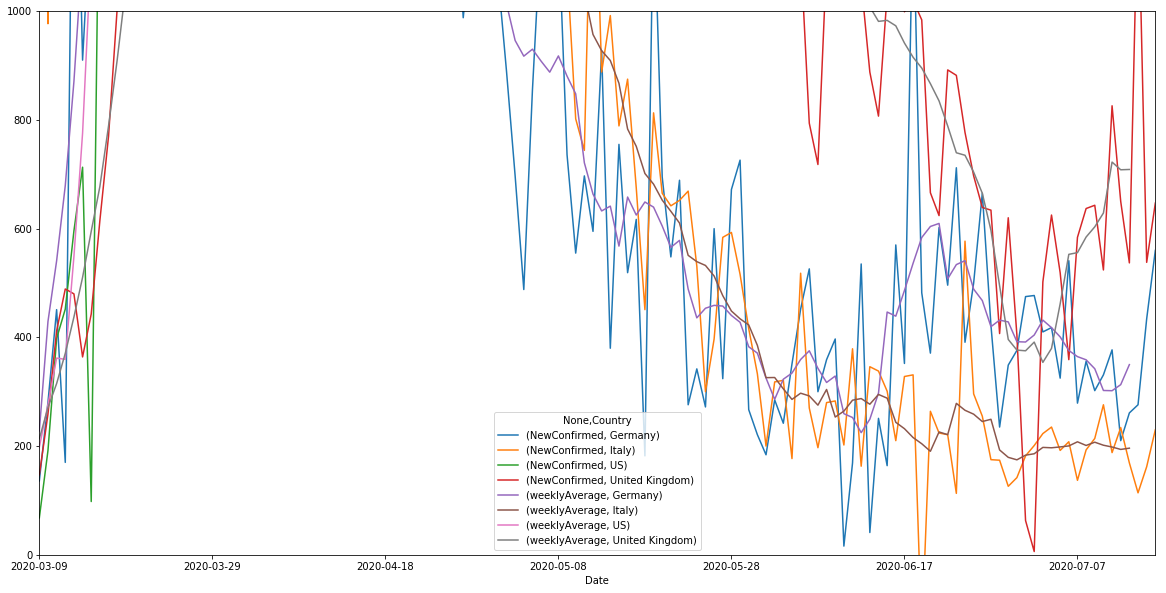

In [48]:
# Filter ...
to_plot = df.loc[
    df.index.get_level_values("Country").isin(countries),
    df.columns.get_level_values(0).isin(["weeklyAverage", 'NewConfirmed'])
    ]

# .. and plot 
unstacked = to_plot.unstack(level="Country").iloc[-lastXdays:].dropna(how = 'all')\

unstacked.plot(
    figsize = (20,10), 
    logy=True,
    ylim = (50,to_plot.max().max())
);

unstacked.plot(
    figsize = (20,10), 
    logy=False,
    ylim = (0,1000)
);

# Reproduction rate for Germany

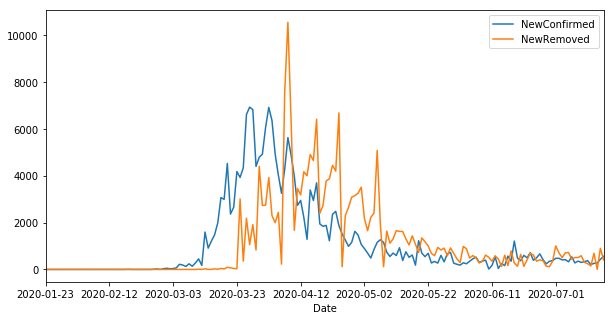

In [50]:
repro_df = df.loc['Germany',["NewConfirmed","NewRemoved"]].dropna(how="any")
repro_df.plot(figsize = (10,5))

# Compute typical duration of lag between infection and recovery
assuming this is the time you are contagious

Shifting by  -12.0  Gives the best alignment of cases


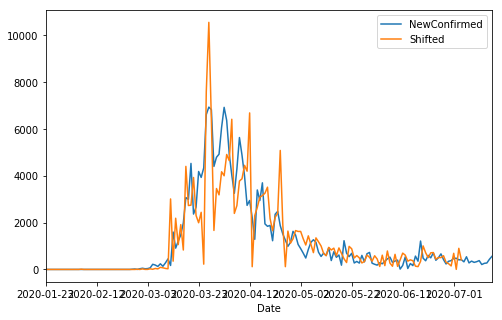

In [51]:
array = repro_df.values.T
shift = pd.np.correlate(array[0], array[1],"same").argmax() - len(repro_df)/2
# More exact would be some fitting and comparing, but this will do for now

print("Shifting by ",shift," Gives the best alignment of cases")
repro_df["Shifted"] = repro_df.loc[:,"NewRemoved"].shift(int(shift))
repro_df.loc[:,["NewConfirmed","Shifted"]].plot(figsize = (8,5))

# Compute an approximation of the Base reproductive number

In [52]:
# Repro = New Infections over next 12 days / current infectionsBAse

In [53]:
df["Repro"] = df["NewConfirmed"]/df["NewConfirmed"].groupby(level = 0).rolling(int(-shift), center = False ).mean().values
df["weeklyRepro"] = df.groupby(level = 0)["Repro"].rolling(7, center = True ).mean().values


# Plot Reproductive number approximation

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


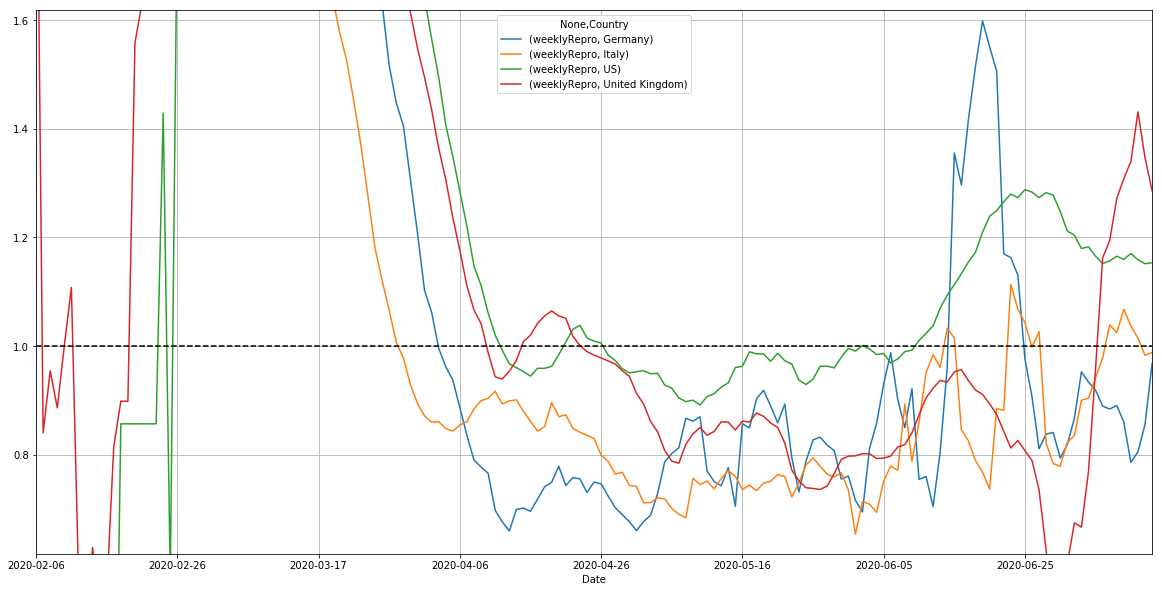

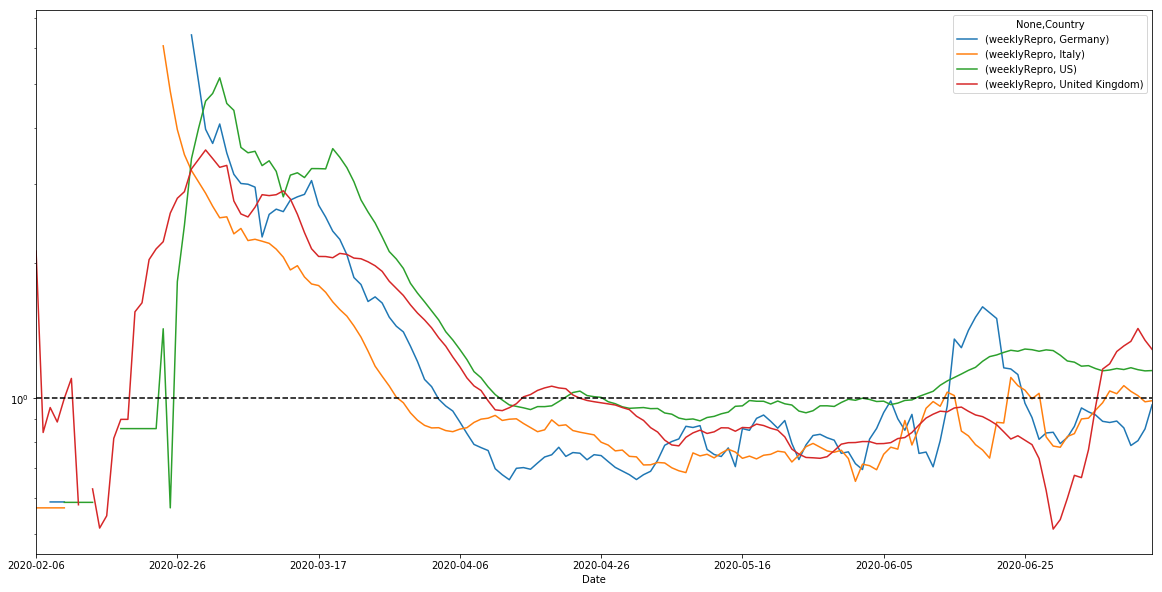

In [62]:
# Filter ...
to_plot = df.loc[
    df.index.get_level_values("Country").isin(countries),
    df.columns.get_level_values(0).isin(["weeklyRepro"])
    ]

# .. and plot 
unstacked = to_plot.unstack(level="Country").dropna(how = 'all')\

ax = unstacked.plot(
    figsize = (20,10), 
    logy=False,
    ylim = (0.61803,1.61803), # Easter egg
    grid = True 
);
ax.plot(ax.get_xlim(),[1.0,1.0], "k--") # Add the line at "1"


ax2 = unstacked[unstacked>0.5].plot(
    figsize = (20,10), 
    logy=True,
);

ax2.plot(ax.get_xlim(),[1.0,1.0], "k--")


